In [ ]:
import math
import random
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
from math import floor
from itertools import combinations
from collections import defaultdict
from networkx import NetworkXException
from networkx.algorithms.approximation import steiner_tree

<div class="alert alert-block alert-info">
<b>🌌Graph:</b> fidelity-aware distribution of a 3-qubit GHZ state
using site-bond percolation to model the underlying quantum network.
</div>

_Initialize the Graph_

In [ ]:
def build_initial_grid(w, h):
    G = nx.Graph()
    for i in range(w):
        for j in range(h):
            G.add_node((i, j))
            parity = (i + j) % 2
            ni = i + 1
            if 0 <= ni < w:
                G.add_edge((i, j), (ni, j))
            if parity == 0 and j + 1 < h:
                G.add_edge((i, j), (i, j + 1))
            elif parity == 1 and j - 1 >= 0:
                G.add_edge((i, j), (i, j - 1))
    return G

_site-bond percolation_

In [ ]:
def percolate_graph(G, w, h, p, q, p_f, terminals):
    Gp = G.copy()
    # Bond
    for edge in list(Gp.edges):
        if random.random() > p:
            Gp.remove_edge(*edge)
        else:
            if random.random() < p_f:
                Gp.edges[edge]['fidelity'] = 1.0
            else:
                Gp.edges[edge]['fidelity'] = random.uniform(0.9, 1.0)
    # Site
    cnt = 0
    for component in nx.connected_components(Gp):
        if set(terminals) <= component:
            cnt += 1
            surviving_nodes = set()
            for node in component:
                if node in terminals or random.random() <= q:
                    surviving_nodes.add(node)
    if cnt == 1:
        print("the cnt is:", cnt)
        return Gp.subgraph(surviving_nodes).copy()
    else:
        print("the cnt is:", cnt)
        return Gp.copy()
# ========================================================================================================
# calculate the tree
def compute_steiner_tree(G, terminals, weight=None):
    if G != None:
        comp = nx.node_connected_component(G, next(iter(terminals)))
        if set(terminals) <= comp:
            return steiner_tree(G.subgraph(comp).copy(), set(terminals), weight=weight, method="kou")
    return None

_fidelity of the chain_

In [ ]:
def compute_fidelity_along_path(G, path):
    # Zero- or one-node path: by definition, fidelity = 1.0
    if len(path) <= 1:
        return 1.0
    fidelity = G[path[0]][path[1]]["fidelity"]
    for u, v in zip(path[1:-1], path[2:]):
        f_next = G[u][v].get("fidelity", 1.0)
        fidelity = fidelity * f_next + ((1 - fidelity) * (1 - f_next)) / 3
    return fidelity
# ========================================================================================================
def analyze_steiner_tree_fidelity(Gp, T, terminals):
    terminals = set(terminals)
    candidates = [n for n in T if T.degree[n] == max(dict(T.degree()).values())]
    center = next((n for n in candidates if n in terminals), candidates[0])
    #print(f"Center node: {center}")
    fidelity_dict = {}
    for terminal in terminals:
        if terminal != center:
            path = nx.shortest_path(T, center, terminal)
            fidelity = compute_fidelity_along_path(Gp, path)
            fidelity_dict[terminal] = fidelity
        else:
            fidelity_dict[center] = 1.0
    return fidelity_dict
# ========================================================================================================
# final fidelity
def compute_final_fidelity(F1, F2, F3):
    eps1 = (1 - F1) / 3
    eps2 = (1 - F2) / 3
    eps3 = (1 - F3) / 3
    e1 = eps1 + eps2 + eps3
    e2 = eps1 * eps2 + eps1 * eps3 + eps2 * eps3
    e3 = eps1 * eps2 * eps3
    F4 = 1 - 3 * e1 + 10 * e2 - 32 * e3
    return F4

📉_Visualize_

In [ ]:
def visualize_parity_grid_with_abc(G, w, h, T=None, scale=0.8):
    pos = { (i, j): (scale * i, -scale * j) for (i, j) in G.nodes }

    A = (1, 1)
    B = (w - 2, h - 2)
    C = (w - 2, 1)

    terminals = {A, B, C}
    special_nodes = [n for n in terminals if n in G]
    regular_nodes = [n for n in G.nodes if n not in special_nodes]

    fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

    # Draw regular nodes
    nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, node_color='#4F8FC0', node_size=100, ax=ax)

    # Draw special nodes with different colors
    if A in G:
        nx.draw_networkx_nodes(G, pos, nodelist=[A], node_color='#62A87C', node_size=200, ax=ax)
    if B in G:
        nx.draw_networkx_nodes(G, pos, nodelist=[B], node_color='#7EE081', node_size=200, ax=ax)
    if C in G:
        nx.draw_networkx_nodes(G, pos, nodelist=[C], node_color='#C3F3C0', node_size=200, ax=ax)

    # Draw base graph edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.0, ax=ax)

    # Draw Steiner tree if provided
    if T is not None and len(T.edges) > 0:
        nx.draw_networkx_edges(T, pos, edge_color='black', width=2.5, ax=ax)

    # Add labels for A, B, C if present
    labels = {n: lbl for n, lbl in zip([A, B, C], ['A', 'B', 'C']) if n in G}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black', ax=ax)

    ax.set_title("Parity Grid with A, B, C + Steiner Tree")
    ax.axis('off')
    plt.show()

the cnt is: 1


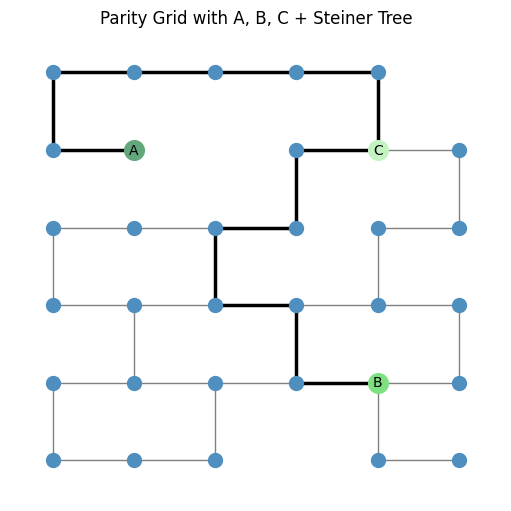

fidelity dictionary: {(4, 4): 0.9006291838415537, (1, 1): 0.8517339472959763, (4, 1): 1.0}
Final GHZ fidelity is: 0.76873348521063


In [ ]:
p = 0.90
q = 0.95
p_f = 0.70
w = 6
h = 6
A = (1, 1)
B = (w - 2, h - 2)
C = (w - 2, 1)
terminals = {A, B, C}
# ---------------------------------------------------------------------------------------------------------
G = build_initial_grid(w, h)
Gp = percolate_graph(G, w, h, p, q, p_f, terminals)
T = compute_steiner_tree(Gp, terminals)
visualize_parity_grid_with_abc(Gp, w, h, T=T)
if T is not None:
    fidelity_dict = analyze_steiner_tree_fidelity(Gp, T, terminals)
    F_vals = [fidelity_dict[t] for t in terminals]
    fidelity_ghz = compute_final_fidelity(*F_vals)
    print(f"fidelity dictionary: {fidelity_dict}")
    print(f"Final GHZ fidelity is: {fidelity_ghz}")
else:
    print("❌ No valid Steiner tree exists.")

<div class="alert alert-block alert-info">
<b>📡Hypergraph:</b> fidelity-aware distribution of a 3-qubit GHZ state
using site-bond percolation to model the underlying quantum network.
</div>

✌*Visualization Helps*

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import networkx as nx

def visualize_hypergraph_layers(G1, G2, w, h, *,
                                terminals=None,
                                factor_nodes=None,
                                scale=0.8,
                                title1="Layer 1: Bipartite (G1)",
                                title2="Layer 2: Multipartite (G2)"):


    terminals = set(terminals or [])
    factor_nodes = set(factor_nodes or [])

    # Consistent grid positions across both layers
    def pos_for(G):
        return {(i, j): (scale * i, -scale * j) for (i, j) in G.nodes}

    pos1 = pos_for(G1)
    pos2 = pos_for(G2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

    # ---------- Layer 1 (G1): base graph -------------------------------------------------------------------------------------
    base_nodes_G1 = [n for n in G1.nodes if n not in terminals]
    if base_nodes_G1:
        nx.draw_networkx_nodes(G1, pos1, nodelist=base_nodes_G1, node_size=100, ax=ax1)
    if terminals:
        present_terms = [t for t in terminals if t in G1]
        if present_terms:
            nx.draw_networkx_nodes(G1, pos1, nodelist=present_terms, node_color='lightgreen', node_size=200, ax=ax1)
            nx.draw_networkx_labels(G1, pos1, labels={t: chr(65+i) for i, t in enumerate(present_terms)}, ax=ax1)
    if G1.number_of_edges() > 0:
        nx.draw_networkx_edges(G1, pos1, width=1.2, ax=ax1)

    ax1.set_title(title1)
    ax1.axis('off')
    ax1.set_aspect('equal', adjustable='box')
    ax1.add_patch(Rectangle((0, 0), 1, 1, transform=ax1.transAxes, fill=False, edgecolor='black', linewidth=2))

    # ---------- Layer 2 (G2): factor graph -------------------------------------------------------------------------------------
    # Split nodes into factor vs base for styling
    factors_in_G2 = [n for n in factor_nodes if n in G2]
    base_nodes_G2 = [n for n in G2.nodes if n not in factor_nodes]

    if base_nodes_G2:
        nx.draw_networkx_nodes(G2, pos2, nodelist=base_nodes_G2, node_size=100, ax=ax2)
    if factors_in_G2:
        nx.draw_networkx_nodes(G2, pos2, nodelist=factors_in_G2, node_size=250, node_color='orchid', node_shape='s', ax=ax2)

    if G2.number_of_edges() > 0:
        nx.draw_networkx_edges(G2, pos2, width=1.2, ax=ax2)

    ax2.set_title(title2)
    ax2.axis('off')
    ax2.set_aspect('equal', adjustable='box')
    ax2.add_patch(Rectangle((0, 0), 1, 1, transform=ax2.transAxes, fill=False, edgecolor='black', linewidth=2))

    return fig, (ax1, ax2)

*Initialize the Hypergraph*

✅ *Checked*

In [ ]:
def build_hypergraph(w, h):
    G1 = build_initial_grid(w, h)
# ---------------------------------------------------------------------------------------------------------
    # potential bug: unwanted nodes are added at parity check
    G2 = nx.Graph()
    factor_node_list = set()
    for i in range(w):
        for j in range(h):
            G2.add_node((i, j))
            parity = (i + j) % 2
            if parity == 1: # parity 1 are the base nodes
                if j + 1 < h and i + 2 < w:
                    G2.add_edge((i + 1, j), (i, j))
                    G2.add_edge((i + 1, j), (i + 1, j + 1))
                    G2.add_edge((i + 1, j), (i + 2, j))
                    factor_node_list.add((i + 1, j))
    hyperg = [G1, G2]
    return [hyperg, factor_node_list]

_Multiplex hypergraph Percolation_

✅ *Checked*

In [ ]:
def percolate_hypergraph(hyperg, factor_initial, p, q, p_f, terminals):
    G1 = hyperg[0].copy()
    G2 = hyperg[1].copy()

    # ========================================================================================================
    # Bond percolation on G1 edges with fidelity
    for edge in list(G1.edges):
        if random.random() > p:
            G1.remove_edge(*edge)
        else:
            G1.edges[edge]['fidelity'] = 1.0 if random.random() <= p_f else random.uniform(0.9, 1.0)

    # ========================================================================================================
    # Hyperedge percolation: keep factor nodes with probability p (others removed via subgraph)
    # Note that here G2 is not updated
    factor_node_list = [node for node in factor_initial if random.random() <= p]

    for node in factor_node_list:
        G2.nodes[node]['fidelity'] = 1.0 if random.random() <= p_f else random.uniform(0.9, 1.0)

    # ========================================================================================================
    # Site percolation: keep nodes with probability q or if they are terminals
    survived1 = {node for node in G1.nodes if node in set(terminals) or random.random() <= q}

    # Update G1
    G1 = G1.subgraph(survived1).copy()

    # Keep base nodes that survived and are also in G2
    survived2 = ((survived1 - set(factor_initial)) & set(G2.nodes)) | set(factor_node_list)

    G2 = G2.subgraph(survived2).copy() # G2 is updated

    # Filter out factor nodes with degree less than number of terminals
    factor_node_up = [node for node in factor_node_list if node in G2 and G2.degree[node] == 3]

    invalid_factors = set(factor_node_list) - set(factor_node_up)
    G2.remove_nodes_from(invalid_factors)

    return [G1, G2, factor_node_up]

☂ *helper funcions*

In [ ]:
# take the factor node coordinate as the input and return the corresponding base nodes
def factor_to_base_nodes(factor_node):
    i, j = factor_node
    return {(i - 1, j), (i, j + 1), (i + 1, j)}

# ========================================================================================================
# Finds shortest paths for any list of (tag, s, t) pairs
def edge_disjoint_min_total(G, pairs):
    best = None
    for order in itertools.permutations(pairs):
        H = G.copy()
        paths = {}
        total_len = 0
        ok = True
        for tag, s, t in order:
            try:
                path = nx.shortest_path(H, s, t)
            except nx.NetworkXNoPath:
                ok = False
                break
            paths[tag] = path
            total_len += len(path) - 1  # number of edges
            H.remove_edges_from(zip(path, path[1:]))  # enforce disjointness
        if ok and (best is None or total_len < best[0]):
            best = (total_len, paths)

    return (False, {}, 0) if best is None else (True, best[1], best[0])

# ========================================================================================================
def edges_of(path, *, undirected=True):
    if len(path) <= 1:
        return set()
    if undirected:
        return {tuple(sorted(e)) for e in zip(path, path[1:])}
    return set(zip(path, path[1:]))

*Creating the Dictionary*

✅ *Checked*

In [ ]:
# Dictionary is {'factor-node', 'base-nodes', 'hyperedge-fidelity'}

def build_level1_dict(G2, factor_nodes):
    # Level-1 dictionary of initial 3-qubit GHZ hyperedges
    d = {}
    for n in factor_nodes:
        # get the hyperedge fidelity, report if missing
        if 'fidelity' not in G2.nodes[n]:
            raise ValueError(f"Missing 'fidelity' for factor node {n} in G2")

        fid = G2.nodes[n]['fidelity']
        d[n] = {'factor-node': n, 'base-nodes': factor_to_base_nodes(n), 'hyperedge-fidelity': fid}
    return d

*Calculate the Path and Fidelity*

✅ *Checked*

In [ ]:
def select_best_factor_fidelity(d, G1, G2, terminals, *, warn_if_nondisjoint=True):

    terminals_tuple = tuple(sorted(terminals))  # deterministic order: (A, B, C)

    # Per-factor: compute the best assignment
    for key, value in d.items():
        base_nodes = list(factor_to_base_nodes(value['factor-node'])) # we take one factor-node from the list
        min_distance = math.inf
        min_base_nodes = None
        min_paths = None

        for b1, b2, b3 in itertools.permutations(base_nodes, 3):
            ok, paths_dict, total_len = edge_disjoint_min_total(G1, [('t1', terminals_tuple[0], b1), ('t2', terminals_tuple[1], b2), ('t3', terminals_tuple[2], b3)])

            # The question is out of all the base-node combinations of that factor-node, which edge-disjoint paths to the terminals has the minimum distance
            if ok and total_len < min_distance:
                min_distance = total_len
                min_base_nodes = (b1, b2, b3)
                min_paths = paths_dict

        # If the answer is infinity then the given factor-node has no functional paths to the terminals
        value.update({'base-nodes': min_base_nodes, 'distance': min_distance, 'paths': min_paths})

    # ========================================================================================================
    # === Unified check: empty dict OR all distances == ∞
    if not d or all(math.isinf(val['distance']) for val in d.values()):
        # print("No feasible terminal→base assignments; trying Steiner fallback.")
        T = compute_steiner_tree(G1, terminals_tuple)
        if T is None:
            # print("No valid Steiner tree exists.")
            return False, None

        fidelity_dict = analyze_steiner_tree_fidelity(G1, T, terminals_tuple)
        F_vals = [fidelity_dict[t] for t in terminals_tuple]
        fidelity_ghz = compute_final_fidelity(*F_vals)
        #return False, fidelity_ghz, T
        return True, fidelity_ghz

    # ========================================================================================================
    # Otherwise, pick the best factor (smallest distance)
    best_key, best_val = min(d.items(), key=lambda kv: kv[1]['distance'])

    # Compute fidelities
    f_t1 = compute_fidelity_along_path(G1, best_val['paths']['t1'])
    f_t2 = compute_fidelity_along_path(G1, best_val['paths']['t2'])
    f_t3 = compute_fidelity_along_path(G1, best_val['paths']['t3'])

    f_GHZ = G2.nodes[best_val['factor-node']]['fidelity']
    f_GHZ = f_GHZ * f_t1 + ((1 - f_GHZ) * (1 - f_t1)) / 7
    f_GHZ = f_GHZ * f_t2 + ((1 - f_GHZ) * (1 - f_t2)) / 7
    f_GHZ = f_GHZ * f_t3 + ((1 - f_GHZ) * (1 - f_t3)) / 7

    #return True, f_GHZ, best_val
    return True, f_GHZ

In [ ]:
def run_hypergraph(w, h, p, q, p_f, fid_thresh, terminals, N_trials):

    R_raw = 0
    R_fid = 0
    fid_mean = 0
    for n in N_trials:
        # -------------------initialize the graph-------------------
        hyperg, factor_initial = build_hypergraph(w, h)
        # -------------------perform percolation-------------------
        G1, G2, factor_node_up = percolate_hypergraph(hyperg, factor_initial, p, q, p_f, terminals)
        # -------------------create the first level dictionary-------------------
        d = build_level1_dict(G2, factor_node_up)
        # -------------------find the best factor node-------------------
        ok, ghz_f = select_best_factor_fidelity(d, G1, G2, terminals)
        if ok:
            # success at m=2 or m=1
            R_raw =+ 1
            if ghz_f > fid_thresh:
                R_fid =+ 1
                fid_mean =+ ghz_f
                fid_mean = fid_mean / len(fid_mean)
        # -------------------return the value-------------------
        return R_raw, R_fid, fid_mean

In [ ]:
w = 6
h = 6
A = (1, 1)
B = (w - 2, h - 2)
C = (w - 2, 1)
p = 0.90 # bond percolation
q = 0.85 # site percolation
p_f = 0.70
terminals = {A, B, C}









(4, 4): {'factor-node': (4, 4), 'base-nodes': {(4, 5), (5, 4), (3, 4)}, 'hyperedge-fidelity': 0.9717318427043629}
(2, 4): {'factor-node': (2, 4), 'base-nodes': {(2, 5), (3, 4), (1, 4)}, 'hyperedge-fidelity': 1.0}
(4, 0): {'factor-node': (4, 0), 'base-nodes': {(5, 0), (4, 1), (3, 0)}, 'hyperedge-fidelity': 0.9529003449004216}
(3, 1): {'factor-node': (3, 1), 'base-nodes': {(3, 2), (4, 1), (2, 1)}, 'hyperedge-fidelity': 1.0}
(1, 1): {'factor-node': (1, 1), 'base-nodes': {(0, 1), (1, 2), (2, 1)}, 'hyperedge-fidelity': 1.0}
(2, 0): {'factor-node': (2, 0), 'base-nodes': {(1, 0), (2, 1), (3, 0)}, 'hyperedge-fidelity': 1.0}
(4, 2): {'factor-node': (4, 2), 'base-nodes': {(5, 2), (3, 2), (4, 3)}, 'hyperedge-fidelity': 1.0}
(3, 3): {'factor-node': (3, 3), 'base-nodes': {(2, 3), (3, 4), (4, 3)}, 'hyperedge-fidelity': 0.9720061446049026}
(2, 2): {'factor-node': (2, 2), 'base-nodes': {(2, 3), (3, 2), (1, 2)}, 'hyperedge-fidelity': 0.9405810411536025}
The final GHZ fidelity is: 0.8735203022853483
Fac

(<Figure size 1200x600 with 2 Axes>,
 (<Axes: title={'center': 'Layer 1: Bipartite (G1)'}>,
  <Axes: title={'center': 'Layer 2: Multipartite (G2)'}>))

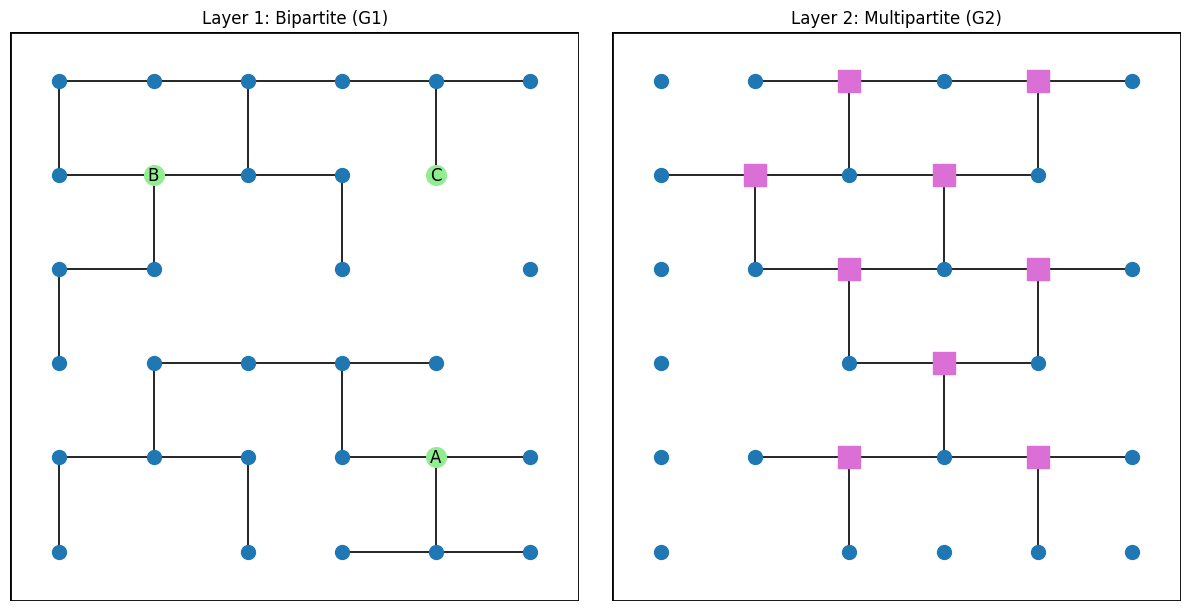

In [ ]:
w = 6
h = 6
A = (1, 1)
B = (w - 2, h - 2)
C = (w - 2, 1)
p = 0.90 # bond percolation
q = 0.85 # site percolation
p_f = 0.70
terminals = {A, B, C}
# -------------------initialize the graph-------------------
hyperg, factor_initial = build_hypergraph(w, h)
# -------------------perform percolation-------------------
G1, G2, factor_node_up = percolate_hypergraph(hyperg, factor_initial, p, q, p_f, terminals)
# -------------------create the first level dictionary-------------------
d = build_level1_dict(G2, factor_node_up)                                       # the firsl level dictionary
for key, value in d.items():
    print(f"{key}: {value}")

ok, ghz_f, dic_factor = select_best_factor_fidelity(d, G1, G2, terminals)
if ok:
    print(f"The final GHZ fidelity is: {ghz_f}")
    print(f"Factor node is: {dic_factor}")
else:
    print(f"The final GHZ fidelity is: {ghz_f}")
    print(f"The Steiner tree is: {dic_factor}")

visualize_hypergraph_layers(G1, G2, w, h, terminals={A,B,C}, factor_nodes=factor_node_up)

*detecting potential hyperedges for distance extension*

✅ *Checked*

In [ ]:
# ========================================================================================================

#⛳ hyperedge fidelity Calculation (processing . . .)
def final_hyperedge_fidelity(G2, hypf1, hypf2, hypf3, f_bc, f_de, f_fa):

    # sanity check!
    for _f in (hypf1, hypf2, hypf3):
        if _f not in G2 or 'fidelity' not in G2.nodes[_f]:
            raise ValueError(f"Factor node {_f} missing or lacks 'fidelity' in G2")

    # first BSM between Bell State and the GHZ state
    fid_a = G2.nodes[hypf1]['fidelity'] * f_bc + ((1 - G2.nodes[hypf1]['fidelity']) * (1 - f_bc)) / 7
    fid_b = G2.nodes[hypf2]['fidelity'] * f_de + ((1 - G2.nodes[hypf2]['fidelity']) * (1 - f_de)) / 7
    fid_c = G2.nodes[hypf3]['fidelity'] * f_fa + ((1 - G2.nodes[hypf3]['fidelity']) * (1 - f_fa)) / 7
    # second BSM between the three GHZ states
    return fid_a * fid_b * fid_c

In [ ]:
def can_expand_hyperedge(G1, G2, terminals, hyp_F1, hyp_F2, hyp_F3):

    # the input is the factor node's coordinates
    F1 = set(factor_to_base_nodes(hyp_F1))
    F2 = set(factor_to_base_nodes(hyp_F2))
    F3 = set(factor_to_base_nodes(hyp_F3))

    # ========================================================================================================
    # a,b in F1; c,d in F2; e,f in F3 such that paths b~c, d~e, f~a exist in G.
    # Precompute reachability for the 9 nodes
    candidates = F1 | F2 | F3

    # ----------------------------------------------Sanity Checks----------------------------------------------
    # base nodes
    missing = [u for u in candidates if u not in G1]
    if missing:
        raise ValueError(f"Base nodes missing from G1 after percolation: {missing}")
    # terminals
    missing_t = [t for t in terminals if t not in G1]
    if missing_t:
        raise ValueError(f"Terminals missing from G1 after percolation: {missing_t}")
    if len(terminals) != 3:
        raise ValueError("Expected exactly three terminals.")
    # factor nodes
    if not (len(F1) == 3 and len(F2) == 3 and len(F3) == 3):
        raise ValueError(f"Each factor must map to exactly 3 base nodes; got |F1|={len(F1)}, |F2|={len(F2)}, |F3|={len(F3)}")

    # ========================================================================================================

    reach = {u: (candidates & set(nx.single_source_shortest_path_length(G1, u))) for u in candidates} # the path should exist in G1

    min_distance = float('inf')
    best_tree_sets = None
    best_remaining = None
    best_paths_tree = None
    best_paths_terminals = None

    # Try all ordered pairs (permutations) from each triple (3P2 = 6 each → 216 combos total)
    for a, b in itertools.permutations(F1, 2):
        for c, d in itertools.permutations(F2, 2):
            for e, f in itertools.permutations(F3, 2):

                # 1. There Should Be Three Intermediate Paths b~c, d~e, and f~a
                if (c in reach[b]) and (e in reach[d]) and (a in reach[f]):

                    # 2. Calculate the length for the minimum
                    Condition1, paths_dict, total_length = multi_shortest_total(G1, [('bc', b, c), ('de', d, e), ('fa', f, a)])

                    # ========================================================================================================

                    if Condition1:
                        # next(iter(..)) means : give me the only element of this singleton set
                        base_nodes_remaining = (next(iter(F1 - {a, b})),
                                                next(iter(F2 - {c, d})),
                                                next(iter(F3 - {e, f})))

                        P_bc = paths_dict['bc'] # list of nodes along b~c
                        P_de = paths_dict['de'] # list of nodes along d~e
                        P_fa = paths_dict['fa'] # list of nodes along f~a

                        # 3. If remove these path's edges from G1, then there still should be paths from base nodes to terminals
                        # Edge Removal
                        G_temp = G1.copy()
                        G_temp.remove_edges_from(list(zip(P_bc, P_bc[1:])))
                        G_temp.remove_edges_from(list(zip(P_de, P_de[1:])))
                        G_temp.remove_edges_from(list(zip(P_fa, P_fa[1:])))

                        # Check for Paths to Terminals
                        t1, t2, t3 = tuple(terminals)
                        reach_terminals = {u: {v for v in base_nodes_remaining if nx.has_path(G_temp, u, v)} for u in terminals}

                        best_tb = None
                        Condition2 = False
                        for (b1, b2, b3) in itertools.permutations(base_nodes_remaining):
                            # quick filter (----------fast----------)
                            if not (b1 in reach_terminals[t1] and b2 in reach_terminals[t2] and b3 in reach_terminals[t3]):
                                continue
                            ok2, paths_dict2, total_length2 = multi_shortest_total(G_temp, [('t1', t1, b1), ('t2', t2, b2), ('t3', t3, b3)])
                            if ok2 and (best_tb is None or total_length2 < best_tb[0]):
                                best_tb = (total_length2, paths_dict2)
                                Condition2 = True

                        # ========================================================================================================

                        if Condition2:
                            # now we should check if these sets of a,b,c,d,e and f are the optimum
                            if (total_length + best_tb[0]) < min_distance:
                                min_distance = total_length + best_tb[0]
                                best_tree_sets = (a, b, c, d, e, f)
                                best_remaining = base_nodes_remaining
                                best_paths_tree = {'bc': P_bc, 'de': P_de, 'fa': P_fa}
                                best_paths_terminals = best_tb[1]

    if min_distance == float('inf'):
        return {
            "success": False,
            "remaining_bases": None,
            "tree_sets": None,
            "paths_tree": None,
            "paths_terminals": None,
            "fidelity": None,
            }

    # ========================================================================================================
    # first calculate path fidelities (bipartite entanglement)
    a, b, c, d, e, f = best_tree_sets
    P_bc = best_paths_tree['bc']; P_de = best_paths_tree['de']; P_fa = best_paths_tree['fa']

    # !🐔🐔🐔! We are aware that these paths are not necessarily edge-disjoint, However we take this approximation for now
    f_bc = compute_fidelity_along_path(G1, P_bc)
    f_de = compute_fidelity_along_path(G1, P_de)
    f_fa = compute_fidelity_along_path(G1, P_fa)

    # using path fidelities and hyperedge fidelities we calculate the final hyperedge fidelity in G2
    f_combhypedge = final_hyperedge_fidelity(G2, hyp_F1, hyp_F2, hyp_F3, f_bc, f_de, f_fa)
    # return True if such longer-range hyperedge exist, the base nodes and the hyperedge fidelity
    return {
        "success": True,
        "remaining_bases": best_remaining,
        "tree_sets": best_tree_sets,
        "paths_tree": best_paths_tree,
        "paths_terminals": best_paths_terminals,
        "fidelity": f_combhypedge,
        }


*Dictionary*

In [ ]:
# ---------------------------------------------------------------------------------------------------------
def promote_level2_hyperedges(G1, G2, factor_nodes):

    # promote build_level1_dict to longer-range hyperedges if such path exist
    factor_node_dic = {1: {}, 2: {}}
    L2 = {}

    # Build level-1 dict
    L1 = build_level1_dict(G2, factor_nodes)

    # Consider all 3-combinations of factor nodes
    to_remove_from_L1 = set()
    for group in itertools.combinations(factor_nodes, 3):
        # the choisen factor nodes
        F1, F2, F3 = group
        # check if the path for promotion exist
        ok, base_nodes_remaining, f_combhypedge = can_expand_hyperedge(G1, G2, F1, F2, F3)

        # ---------------------------------------------------------------------------------------------------------
        if ok:
            # Create a new dictionary for level 2
            # calculate a new factor-node coordinate which is the mid-point of F1, F2 and F3
            tup_n = (F1[0] + F2[0] + F3[0]) // 3, (F1[1] + F2[1] + F3[1]) // 3
            L2_id = len(L2)
            L2[L2_id] = {
                'factor-node': tup_n,
                'base-nodes': base_nodes_remaining,
                'hyperedge-fidelity': f_combhypedge}
            # remove these factor-nodes from the previous list
            to_remove_from_L1.update(group)

    for n in to_remove_from_L1:
        if n in L1:
            del L1[n]
        else:
            # if factor-nodes are not in the list raise the error
            raise KeyError(f"Factor node {n} not found in L1 dictionary.")

    # ---------------------------------------------------------------------------------------------------------
    factor_node_dic[1] = L1
    factor_node_dic[2] = L2

    return factor_node_dic